In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_pickle('/content/drive/MyDrive/choosen/train.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/choosen/test.pkl')

In [3]:
import cv2
import os
import pandas as pd
from tqdm import tqdm

# Assuming `balanced_df` contains the image names in the 'image' column
imgsTrainin = []
# Output directory for resized images

# Loop through the image names in balanced_df and process them
for image_name in tqdm(train_data['image']):
    # Construct the full image file path
    image_path = os.path.join("/content/drive/MyDrive/choosen/" + image_name + ".jpg")  # Adjust extension if needed

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image {image_name} not found or could not be read.")
        continue

    # Resize the image to 500x500
    resized_image = cv2.resize(image, (224, 224))
    imgsTrainin.append(resized_image)

    # Save the resized image to the output directory
    # output_path = os.path.join(output_directory, image_name + "_resized.jpg")
    # cv2.imwrite(output_path, resized_image)

# Assuming `balanced_df` contains the image names in the 'image' column
imgsTesting = []
# Output directory for resized images

# Loop through the image names in balanced_df and process them
for image_name in tqdm(test_data['image']):
    # Construct the full image file path
    image_path = os.path.join("/content/drive/MyDrive/choosen/" + image_name + ".jpg")  # Adjust extension if needed

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image {image_name} not found or could not be read.")
        continue

    # Resize the image to 500x500
    resized_image = cv2.resize(image, (224, 224))
    imgsTesting.append(resized_image)

    # Save the resized image to the output directory
    # output_path = os.path.join(output_directory, image_name + "_resized.jpg")
    # cv2.imwrite(output_path, resized_image)

print("Image resizing completed.")

100%|██████████| 384/384 [05:05<00:00,  1.26it/s]

Image resizing completed.


In [4]:
labels_one_hot = train_data.iloc[:, 1:].values
labelstrain = [list(row).index(1.0) for row in labels_one_hot]
labels_one_hot = test_data.iloc[:, 1:].values
labelstest = [list(row).index(1.0) for row in labels_one_hot]

In [5]:
import torch
stacked_array = np.stack(labelstrain)  # Shape: (num_samples, 3, 500, 500)
torch_labels_train = torch.from_numpy(stacked_array)

stacked_array = np.stack(labelstest)  # Shape: (num_samples, 3, 500, 500)
torch_labels_test = torch.from_numpy(stacked_array)

stacked_array = np.stack(imgsTrainin)  # Shape: (num_samples, 3, 500, 500)
torch_images_train = torch.from_numpy(stacked_array).float()  # Ensure it's a float tensor

stacked_array = np.stack(imgsTesting)  # Shape: (num_samples, 3, 500, 500)
torch_images_test = torch.from_numpy(stacked_array).float()  # Ensure it's a float tensor

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Example data (replace with your actual tensors)
train_images = torch_images_train.permute(0, 3, 1, 2)
test_images = torch_images_test.permute(0, 3, 1, 2)
train_labels = torch_labels_train
test_labels = torch_labels_test

# Wrap into TensorDataset
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flattened_size = None  # Placeholder to calculate the size dynamically
        self.fc1 = None
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        if self.flattened_size is None:
            # Calculate flattened size dynamically
            self.flattened_size = torch.prod(torch.tensor(x.shape[1:])).item()
            self.fc1 = nn.Linear(self.flattened_size, 256).to(x.device)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
trainingHolder = []
testingHolder = []

num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Testing loop
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    testingHolder.append(100 * correct / total)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    trainingHolder.append(100 * correct / total)

Epoch [1/40], Loss: 2.2025
Test Accuracy: 23.44%
Epoch [2/40], Loss: 2.0187
Test Accuracy: 26.82%
Epoch [3/40], Loss: 1.9728
Test Accuracy: 26.04%
Epoch [4/40], Loss: 1.9399
Test Accuracy: 25.52%
Epoch [5/40], Loss: 1.8907
Test Accuracy: 28.12%
Epoch [6/40], Loss: 1.8504
Test Accuracy: 28.39%
Epoch [7/40], Loss: 1.8060
Test Accuracy: 32.29%
Epoch [8/40], Loss: 1.7757
Test Accuracy: 29.43%
Epoch [9/40], Loss: 1.7491
Test Accuracy: 32.81%
Epoch [10/40], Loss: 1.7149
Test Accuracy: 32.81%
Epoch [11/40], Loss: 1.6895
Test Accuracy: 32.29%
Epoch [12/40], Loss: 1.6612
Test Accuracy: 35.16%
Epoch [13/40], Loss: 1.6433
Test Accuracy: 34.90%
Epoch [14/40], Loss: 1.6084
Test Accuracy: 33.07%
Epoch [15/40], Loss: 1.5993
Test Accuracy: 33.59%
Epoch [16/40], Loss: 1.5766
Test Accuracy: 35.42%
Epoch [17/40], Loss: 1.5460
Test Accuracy: 35.68%
Epoch [18/40], Loss: 1.5189
Test Accuracy: 35.16%
Epoch [19/40], Loss: 1.5002
Test Accuracy: 34.90%
Epoch [20/40], Loss: 1.4844
Test Accuracy: 36.20%
Epoch [21

In [14]:
def test():
  model = SimpleCNN(num_classes=8).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  # Training loop
  trainingHolder = []
  testingHolder = []

  num_epochs = 40
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

      # Testing loop
      model.eval()
      correct = 0
      total = 0

      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      # print(f'Test Accuracy: {100 * correct / total:.2f}%')
      testingHolder.append(100 * correct / total)

      correct = 0
      total = 0
      with torch.no_grad():
          for images, labels in train_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      trainingHolder.append(100 * correct / total)
  return max(testingHolder)

In [ ]:
from tqdm import tqdm

acc = []
for i in tqdm(range(10)):
  acc.append(test())

 80%|████████  | 8/10 [59:10<14:46, 443.30s/it]

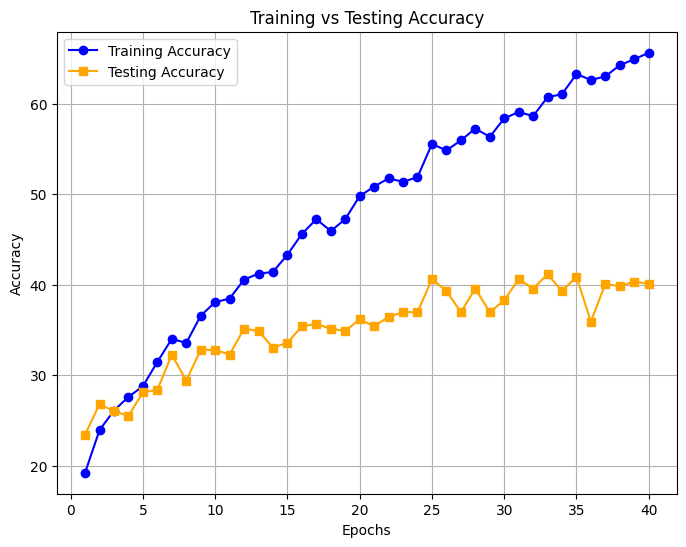

In [8]:
epochs = range(1, len(trainingHolder) + 1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, trainingHolder, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, testingHolder, label='Testing Accuracy', marker='s', color='orange')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [9]:
testingHolder

[23.4375,
 26.822916666666668,
 26.041666666666668,
 25.520833333333332,
 28.125,
 28.385416666666668,
 32.291666666666664,
 29.427083333333332,
 32.8125,
 32.8125,
 32.291666666666664,
 35.15625,
 34.895833333333336,
 33.072916666666664,
 33.59375,
 35.416666666666664,
 35.677083333333336,
 35.15625,
 34.895833333333336,
 36.197916666666664,
 35.416666666666664,
 36.458333333333336,
 36.979166666666664,
 36.979166666666664,
 40.625,
 39.322916666666664,
 36.979166666666664,
 39.583333333333336,
 36.979166666666664,
 38.28125,
 40.625,
 39.583333333333336,
 41.145833333333336,
 39.322916666666664,
 40.885416666666664,
 35.9375,
 40.104166666666664,
 39.84375,
 40.364583333333336,
 40.104166666666664]

In [10]:
max(testingHolder)

41.145833333333336

In [13]:
acc

[18.75,
 16.40625,
 17.447916666666668,
 17.96875,
 16.666666666666668,
 17.708333333333332,
 19.270833333333332,
 16.927083333333332,
 18.489583333333332,
 18.489583333333332]